In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity

In [12]:

def mpPDF(var, q, pts):
    """
    Creates a Marchenko-Pastur Probability Density Function
    Args:
        var (float): Variance
        q (float): T/N where T is the number of rows and N the number of columns
        pts (int): Number of points used to construct the PDF
    Returns:
        pd.Series: Marchenko-Pastur PDF
    """
    # Marchenko-Pastur pdf
    # q=T/N
    # Adjusting code to work with 1 dimension arrays
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
    eMin, eMax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
    pdf = pd.Series(pdf, index=eVal)
    return pdf

def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    """
    Fit kernel to a series of obs, and derive the prob of obs x is the array of values
        on which the fit KDE will be evaluated. It is the empirical PDF
    Args:
        obs (np.ndarray): observations to fit. Commonly is the diagonal of Eigenvalues
        bWidth (float): The bandwidth of the kernel. Default is .25
        kernel (str): The kernel to use. Valid kernels are [‘gaussian’|’tophat’|
            ’epanechnikov’|’exponential’|’linear’|’cosine’] Default is ‘gaussian’.
        x (np.ndarray): x is the array of values on which the fit KDE will be evaluated
    Returns:
        pd.Series: Empirical PDF
    """
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

def getPCA(matrix):
    """
    Gets the Eigenvalues and Eigenvector values from a Hermitian Matrix
    Args:
        matrix pd.DataFrame: Correlation matrix
    Returns:
         (tuple): tuple containing:
            np.ndarray: Eigenvalues of correlation matrix
            np.ndarray: Eigenvectors of correlation matrix
    """
    # Get eVal,eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]  # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

In [20]:
corr_path = "test_folder/corr_matrix" #set folder where correlation matrices are found
file_list = []

for file_name in os.listdir(corr_path):
    file_list.append(file_name)
    
x = np.loadtxt(os.path.join(corr_path,file_list[0]), delimiter=",")
eVal0, eVec0 = getPCA(x)


C:\Users\User\AppData\Local\Temp\ipykernel_8420\3553035729.py:19: RuntimeWarning: divide by zero encountered in divide
  pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
C:\Users\User\AppData\Local\Temp\ipykernel_8420\3553035729.py:19: RuntimeWarning: invalid value encountered in multiply
  pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5


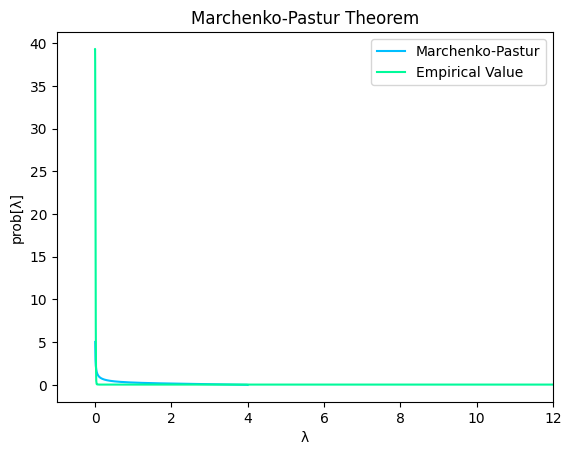

In [22]:
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
# Empirical pdf
pdf1= fitKDE(np.diag(eVal0), bWidth=0.01)

# Plotting results
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
pdf1.plot(label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]", xlim=(-1,12))
ax.legend(loc="upper right")